最終課題用のノートブックのなかに、犬と猫の画像を学習したモデルを作成して、分類を行なうプログラムを作成してください。

本レッスン内容で学習した流れに沿って、深層学習プログラムを作成してください
データの前処理や水増しの処理を入れてください
MobileNetV2 のモデルを利用してください（画像サイズは MobileNetV2 が対応する大きさへのリサイズが必要です）
必ず最後に evaluate() を実行して、正答率がわかるようにしてください。

In [1]:
# 訓練データとテストデータの画像を読み込む
# （サイズは縦横96pxにリサイズする）
import tensorflow as tf

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dog_cat_photos/train",
    image_size=(96, 96),
    label_mode="binary",
    batch_size=32,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dog_cat_photos/test",
    image_size=(96, 96),
    label_mode="binary",
    batch_size=32,
    shuffle=False
)

Found 300 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


In [2]:
# データの詳細を表示する
list(train_dataset.as_numpy_iterator())[0]

2025-08-15 11:31:50.226978: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(array([[[[ 67.       ,  57.       ,   8.       ],
          [ 67.       ,  57.       ,   8.       ],
          [ 67.453125 ,  57.453125 ,   7.546875 ],
          ...,
          [ 31.90625  ,  27.359375 ,   4.       ],
          [ 30.671875 ,  25.671875 ,   3.671875 ],
          [ 30.       ,  25.       ,   3.       ]],
 
         [[ 68.34375  ,  58.34375  ,   9.34375  ],
          [ 68.34375  ,  58.34375  ,   8.440918 ],
          [ 68.796875 ,  58.796875 ,   8.155762 ],
          ...,
          [ 32.945557 ,  28.766113 ,   4.3044434],
          [ 32.015625 ,  27.467041 ,   4.112793 ],
          [ 31.34375  ,  26.34375  ,   4.34375  ]],
 
         [[ 69.       ,  59.       ,   9.09375  ],
          [ 69.       ,  59.       ,   8.358887 ],
          [ 69.453125 ,  59.453125 ,   8.453125 ],
          ...,
          [ 33.453125 ,  29.453125 ,   4.453125 ],
          [ 32.671875 ,  28.492432 ,   4.0307617],
          [ 32.       ,  27.453125 ,   4.09375  ]],
 
         ...,
 
         [[ 

In [3]:
# 分類名（cat/dog）をリストとして格納する
class_names = train_dataset.class_names
class_names

['cat', 'dog']

2025-08-15 11:31:50.318021: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


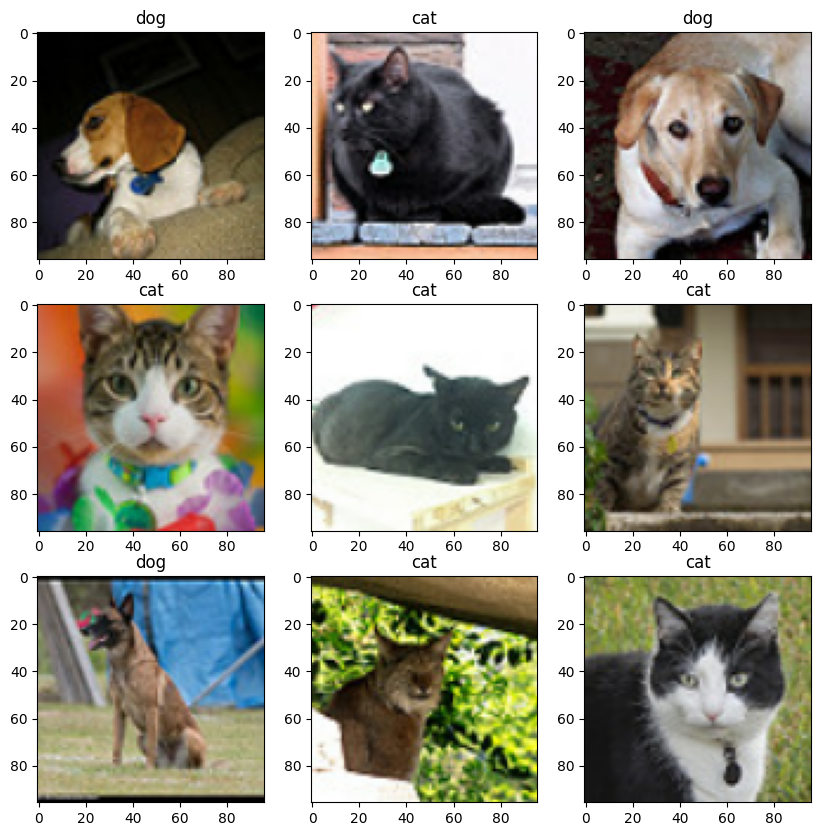

In [4]:
# 訓練データの一部を表示して確認
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])

In [5]:
# 画像の水増しをする関数の定義
def flip_left_right(image, label):   # 左右反転
    image = tf.image.flip_left_right(image)
    return image, label

def flip_up_down(image, label):      # 上下反転
    image = tf.image.flip_up_down(image)
    return image, label

def rot90(image, label):             # 反時計回りに90度回転
    image = tf.image.rot90(image)
    return image, label

def rot180(image, label):            # 反時計回りに180度回転
    image = tf.image.rot90(image, k=2)
    return image, label

def rot270(image, label):            # 反時計回りに270度回転
    image = tf.image.rot90(image, k=3)
    return image, label

In [6]:
# 画像の水増し処理の実行
train_dataset_lr     = train_dataset.map(flip_left_right)
train_dataset_ud     = train_dataset.map(flip_up_down)
train_dataset_rot90  = train_dataset.map(rot90)
train_dataset_rot180 = train_dataset.map(rot180)
train_dataset_rot270 = train_dataset.map(rot270)

In [7]:
# 水増ししたデータを訓練データに追加する
train_dataset = train_dataset.concatenate(train_dataset_lr)
train_dataset = train_dataset.concatenate(train_dataset_ud)
train_dataset = train_dataset.concatenate(train_dataset_rot90)
train_dataset = train_dataset.concatenate(train_dataset_rot180)
train_dataset = train_dataset.concatenate(train_dataset_rot270)

In [8]:
# データをシャッフルする
train_dataset = train_dataset.shuffle(32)

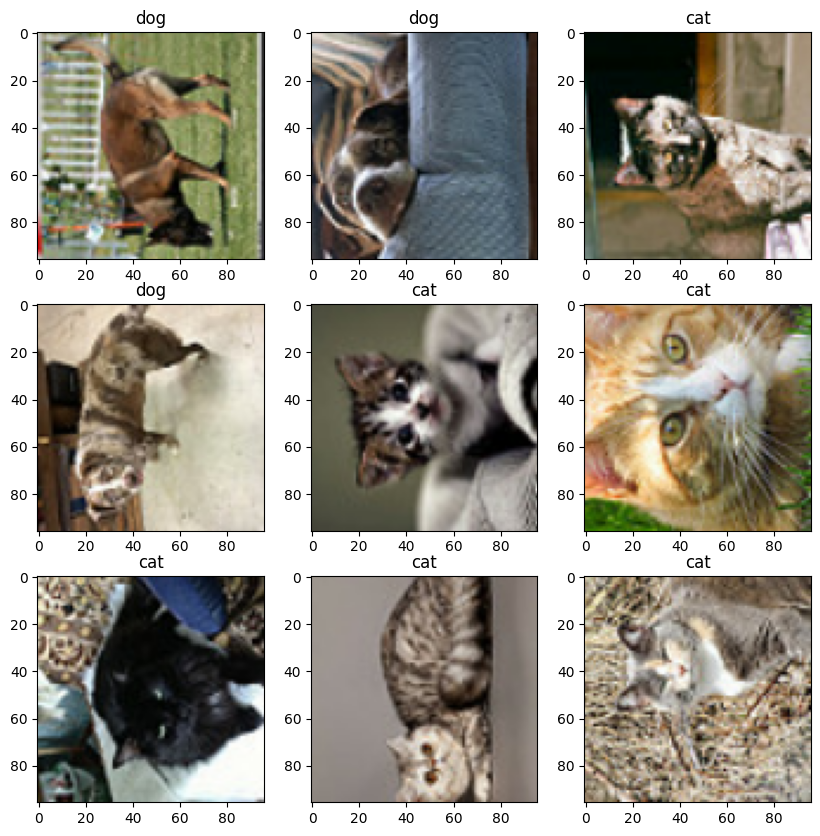

In [9]:
# 訓練データの一部を表示して確認
plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])

In [ ]:
# MobileNetV2モデルを作成する
input_layer = tf.keras.Input(shape=(96, 96, 3))   # 入力層
l_layer = tf.keras.applications.mobilenet_v2.preprocess_input(input_layer)   # 前処理（正規化）をする層

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(96, 96, 3),
    input_tensor=l_layer,
    include_top=False,
    weights="imagenet",
    pooling='avg'
)
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 14s 2us/step


In [11]:
# Dense層を追加する
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

In [12]:
# base_modelに先ほどのDense層を追加したモデルを作成する
model = tf.keras.Sequential([
    base_model,
    output_layer
])

In [13]:
# modelをcompileする
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [14]:
# modelに学習させる
model.fit(train_dataset, epochs=20)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8378 - loss: 0.3609
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9261 - loss: 0.1859
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9500 - loss: 0.1360
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9683 - loss: 0.1063
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9772 - loss: 0.0890
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9822 - loss: 0.0740
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9867 - loss: 0.0646
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9900 - loss: 0.0547
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9917 - loss: 0.0472
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9944 - loss: 0.0419
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9967 - loss: 0.0389
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy:

In [15]:
# テストデータで分類を実行する
pred_data = model.predict(test_dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


In [16]:
# 分類した結果を確認する
pred_data

array([[5.08680334e-03],
       [7.76673609e-04],
       [1.22054975e-04],
       [4.03989048e-04],
       [1.27339130e-03],
       [2.23912392e-03],
       [1.37979776e-04],
       [3.72240203e-04],
       [9.46201675e-04],
       [3.74493044e-04],
       [1.67406062e-04],
       [2.11020298e-02],
       [5.09868783e-04],
       [6.81609064e-02],
       [2.81000423e-04],
       [3.34224373e-04],
       [1.80565551e-01],
       [8.10961181e-04],
       [4.56082635e-04],
       [7.21128832e-04],
       [2.08938043e-04],
       [1.02982875e-02],
       [1.75678011e-04],
       [2.54161714e-04],
       [7.43634224e-01],
       [1.00883088e-04],
       [5.35304379e-03],
       [2.47931632e-04],
       [2.51218170e-01],
       [2.57126032e-03],
       [7.62761012e-03],
       [6.35240614e-01],
       [6.31786997e-06],
       [8.46608018e-04],
       [1.01089443e-03],
       [6.43345714e-01],
       [7.85510838e-02],
       [1.94991044e-05],
       [8.63189867e-04],
       [3.48096626e-04],


In [17]:
# evaluate()でモデルの性能を評価する
model.evaluate(test_dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9700 - loss: 0.0466


[0.046576932072639465, 0.9700000286102295]